## Lab10
#### Pranisaa Charnparttaravanit st121720

This lab consists of three parts which are as follows:

1. Change the structure to be identical to Goodfellow's Figure 10.3 with tanh activation functions and see if you get different results.

2. Explore methods for batching patterns of different length prior to presentation to a RNN and implement them. See how much speedup you can get from the GPU with minibatch training.

3. Do a bit of research on similar problems such as named entity recognition, find a dataset, train a model, and report your results.

### Task1: Change the structure to be identical to Goodfellow's Figure 10.3 with tanh activation functions and see if you get different results.

Here's code directly from the tutorial to read the names into a dictionary of the form { language1: [name1, name2, ...], language2: ... }

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

### 1. Load data

In [2]:
def findFiles(path):
    return glob.glob(path)

print(findFiles('data/names/*.txt'))

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

['data/names/Arabic.txt', 'data/names/Chinese.txt', 'data/names/Czech.txt', 'data/names/Dutch.txt', 'data/names/English.txt', 'data/names/French.txt', 'data/names/German.txt', 'data/names/Greek.txt', 'data/names/Irish.txt', 'data/names/Italian.txt', 'data/names/Japanese.txt', 'data/names/Korean.txt', 'data/names/Polish.txt', 'data/names/Portuguese.txt', 'data/names/Russian.txt', 'data/names/Scottish.txt', 'data/names/Spanish.txt', 'data/names/Vietnamese.txt']


#### 1.1 Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427

In [3]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


#### 1.2 Build the category_lines dictionary, a list of names per language

In [4]:
category_lines = {}
all_categories = []

# Read a file and split into lines

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print('Number of categories: ', n_categories)

Number of categories:  18


In [5]:
# Check that it worked

for c in all_categories[:2]:
    print(c)
    print(category_lines[c]) 

Arabic
['Khoury', 'Nahas', 'Daher', 'Gerges', 'Nazari', 'Maalouf', 'Gerges', 'Naifeh', 'Guirguis', 'Baba', 'Sabbagh', 'Attia', 'Tahan', 'Haddad', 'Aswad', 'Najjar', 'Dagher', 'Maloof', 'Isa', 'Asghar', 'Nader', 'Gaber', 'Abboud', 'Maalouf', 'Zogby', 'Srour', 'Bahar', 'Mustafa', 'Hanania', 'Daher', 'Tuma', 'Nahas', 'Saliba', 'Shamoon', 'Handal', 'Baba', 'Amari', 'Bahar', 'Atiyeh', 'Said', 'Khouri', 'Tahan', 'Baba', 'Mustafa', 'Guirguis', 'Sleiman', 'Seif', 'Dagher', 'Bahar', 'Gaber', 'Harb', 'Seif', 'Asker', 'Nader', 'Antar', 'Awad', 'Srour', 'Shadid', 'Hajjar', 'Hanania', 'Kalb', 'Shadid', 'Bazzi', 'Mustafa', 'Masih', 'Ghanem', 'Haddad', 'Isa', 'Antoun', 'Sarraf', 'Sleiman', 'Dagher', 'Najjar', 'Malouf', 'Nahas', 'Naser', 'Saliba', 'Shamon', 'Malouf', 'Kalb', 'Daher', 'Maalouf', 'Wasem', 'Kanaan', 'Naifeh', 'Boutros', 'Moghadam', 'Masih', 'Sleiman', 'Aswad', 'Cham', 'Assaf', 'Quraishi', 'Shalhoub', 'Sabbag', 'Mifsud', 'Gaber', 'Shammas', 'Tannous', 'Sleiman', 'Bazzi', 'Quraishi', 'Raha

In [6]:
print('5 examples of italian names: ',category_lines['Italian'][:5])

5 examples of italian names:  ['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


### 2. Encode

#### Method1: One-hot encoding of a word vocabulary using scikit-learn’s OneHotEncoder

In [7]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
labelencoder_X = LabelEncoder()
X = [['red'], ['green'], ['blue']]
X = labelencoder_X.fit_transform(X)
# print(X)
# print(X.shape)
encoder = OneHotEncoder(sparse=False)
print(encoder.fit_transform(X.reshape(-1,1)))

[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


/usr/lib/python3/dist-packages/sklearn/preprocessing/label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Method2: One-hot encoding of a word using numpy

In [8]:
import numpy as np

arr = [2, 1, 0]
max = np.max(arr) + 1
print(np.eye(max)[arr])

[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


#### 2.1 Encode names

In [9]:
import torch

# Find letter index from all_letters, e.g. "a" -> 0

def letterToIndex(letter):
    return all_letters.find(letter)

# (For demonstration) turn a letter into a <1 x n_letters> tensor

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters> tensor
# (an array of one-hot letter vectors)

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


### 3. Define RNN model

In [10]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Sequential(nn.Linear(input_size + hidden_size, hidden_size),
                                 nn.Tanh())
        self.i2o = nn.Linear(hidden_size, output_size) #add tanh
        self.softmax = nn.LogSoftmax(dim=1)  #logsoftmax thats why -2.XXX to avoid tiny bit of computation

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(hidden) #take from hidden
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

### 4. Inspection

Below is the implementation of one time step for the model. The forward function takes an input and a previous hidden state, returning the output and the new hidden state.

In [11]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [12]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
output

tensor([[-2.9738, -2.8447, -2.8066, -2.9305, -2.9357, -2.9382, -2.7940, -2.8898,
         -2.9467, -2.9419, -2.9330, -2.8231, -2.9231, -2.9241, -2.8375, -2.9377,
         -2.9117, -2.7680]], grad_fn=<LogSoftmaxBackward>)

In [13]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

next_hidden = hidden
for i in range(input.shape[0]):
    output, next_hidden = rnn(input[i], next_hidden)
    print(output)

tensor([[-2.9738, -2.8447, -2.8066, -2.9305, -2.9357, -2.9382, -2.7940, -2.8898,
         -2.9467, -2.9419, -2.9330, -2.8231, -2.9231, -2.9241, -2.8375, -2.9377,
         -2.9117, -2.7680]], grad_fn=<LogSoftmaxBackward>)
tensor([[-3.0347, -2.8348, -2.7844, -2.8709, -2.9712, -2.9585, -2.8427, -2.8716,
         -2.8743, -3.0025, -2.9169, -2.8201, -2.8660, -2.9132, -2.8825, -2.9148,
         -2.8741, -2.8295]], grad_fn=<LogSoftmaxBackward>)
tensor([[-2.9754, -2.8221, -2.7778, -2.8936, -2.9847, -2.9128, -2.8968, -2.8432,
         -2.9296, -2.9746, -2.9330, -2.8319, -2.8799, -2.9170, -2.8585, -2.9297,
         -2.8681, -2.8270]], grad_fn=<LogSoftmaxBackward>)
tensor([[-2.9539, -2.8573, -2.7907, -2.8806, -2.9682, -2.8994, -2.8989, -2.8501,
         -2.9395, -2.9991, -2.9068, -2.8357, -2.9317, -2.8629, -2.8050, -2.9691,
         -2.9076, -2.8024]], grad_fn=<LogSoftmaxBackward>)
tensor([[-2.9556, -2.8555, -2.7242, -2.8951, -3.0164, -2.9001, -2.8933, -2.8890,
         -2.8710, -3.0030, -2.9369,

### 5. Training

#### 5.1 Converter
To get started with training, we need some helper functions. This one converts an output vector to a category:

In [14]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Czech', 2)


#### 5.2 Get a random element of our training set

In [15]:
import random

def randomChoice(l):
    # random.randint range is inclusive thus len(l)-1
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Vietnamese / line = Than
category = Italian / line = Amoretto
category = Chinese / line = Kwong
category = Russian / line = Jelezny
category = Dutch / line = Heel
category = Vietnamese / line = Ngo
category = Irish / line = Mooney
category = Italian / line = Borghi
category = Portuguese / line = Melo
category = Polish / line = Salomon


#### 5.3 Define loss function and learning rate

In [16]:
criterion = nn.NLLLoss() 
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

#### 5.4 Define train function

In [17]:
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()  

#### 5.5 Actual training

In [18]:
import time
import math

n_iters = 200000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  


5000 2% (0m 21s) 2.8723 Clineburg / Polish ✗ (Czech)
10000 5% (0m 42s) 1.6201 Hwang / Chinese ✗ (Korean)
15000 7% (1m 3s) 1.6307 Johov / Arabic ✗ (Russian)
20000 10% (1m 24s) 2.4282 Holzknecht / Russian ✗ (German)
25000 12% (1m 46s) 0.7306 Trang / Vietnamese ✓
30000 15% (2m 8s) 0.6126 Pispinis / Greek ✓
35000 17% (2m 29s) 0.9138 Santos / Portuguese ✓
40000 20% (2m 50s) 3.3509 Janshole / Scottish ✗ (Russian)
45000 22% (3m 11s) 1.0383 Koziol / Polish ✓
50000 25% (3m 32s) 0.0242 Nguyen / Vietnamese ✓
55000 27% (3m 53s) 3.7001 Yanzhul / Czech ✗ (Russian)
60000 30% (4m 14s) 3.6702 Ino / Vietnamese ✗ (Japanese)
65000 32% (4m 35s) 0.0351 Akrivopoulos / Greek ✓
70000 35% (4m 56s) 2.3189 Gok / Korean ✗ (Chinese)
75000 37% (5m 17s) 0.2074 Matsuda / Japanese ✓
80000 40% (5m 38s) 0.0226 Bassanelli / Italian ✓
85000 42% (5m 59s) 0.1631 Mustafa / Arabic ✓
90000 45% (6m 20s) 0.9200 Severin / French ✓
95000 47% (6m 41s) 0.5036 Sanchez / Spanish ✓
100000 50% (7m 2s) 0.0279 Snijders / Dutch ✓
105000 52%

### 6. Plot

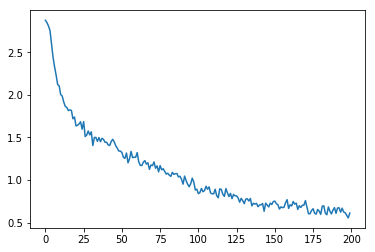

In [22]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

### 7. Confusion matrix

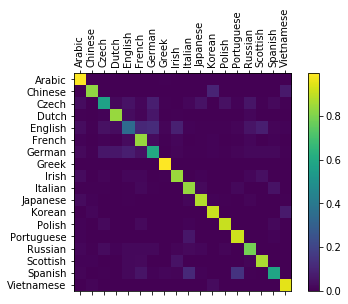

In [20]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

### 8. Prediction

In [21]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Charnparttaravanit')


> Dovesky
(-0.14) Russian
(-2.44) Czech
(-3.22) English

> Jackson
(-0.21) Scottish
(-2.26) English
(-2.84) Russian

> Satoshi
(-0.10) Japanese
(-3.10) Arabic
(-3.44) Italian

> Charnparttaravanit
(-0.06) Russian
(-4.02) Czech
(-4.06) Italian


As shown above, I have tested with my last name, Charnparttaravanit, and apparently it is a russian name!